# Predicting US air travel over the next few years.

## Overview

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [6]:
%matplotlib inline

###  load Data

In [7]:
data = pd.read_csv('air-passengers.csv')

### Explore and transform my data

In [11]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Check datatypes

In [13]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

### Check if any nulls

In [14]:
data.isnull().values.any()

False

### Converting dataframe to a series

In [15]:
from datetime import datetime

### Convert the month to pandas date/time

In [16]:
data['Month'] = pd.to_datetime(data['Month'])

### Set the month col to be an index

In [17]:
data.set_index('Month', inplace = True)

### New Variable called ts that equals passengers col

In [19]:
ts = data['#Passengers']

In [20]:
type(ts)

pandas.core.series.Series

In [21]:
ts.describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64

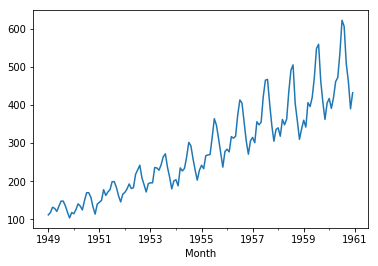

In [22]:
ts.plot()

### Decomposition

#### Data: trend, seasonality, noise. 
Data = the data itself
Seasonality = patterns that repeat in cycles
noise = random variation in the data

### We should use a multiplicative model becasueas time goes on, the general trend seems to be increasing at an increasing rate. We also see that the seasonal ups and downs get bigger and bigger as time passes.

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
decomposition = seasonal_decompose(ts)

### Create 3 variables and set them equal to the decomposition

In [26]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#### Plot the outcome

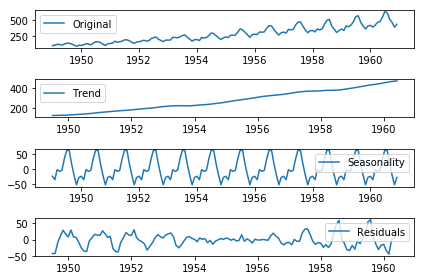

In [27]:
plt.subplot(411)
plt.plot(ts, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

# Model and transform

In [28]:
from statsmodels.tsa.stattools import kpss

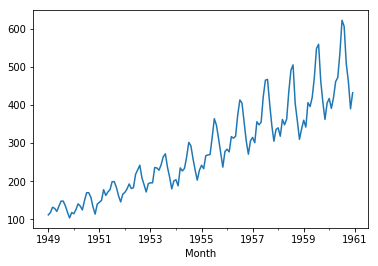

In [31]:
ts.plot()

In [33]:
ts_log = np.log(ts)

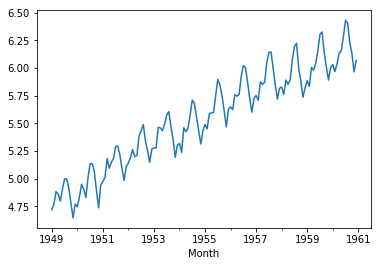

In [34]:
ts_log.plot()

In [35]:
ts_log.diff().head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

In [36]:
kpss(ts_log.diff().dropna())

T:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.10154458687402604,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### ARIMA MODEL

In [41]:
# These are the relevant libraries we'll use.
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [42]:
# This method finds the MSE of a single ARIMA model.
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) # Needs to be an integer because it is later used as an index.
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model.
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# This method evaluates ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [43]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [44]:
evaluate_models(ts, p_values, d_values, q_values)

T:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
T:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
T:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which

ARIMA(0, 0, 1) MSE=11363.167
ARIMA(0, 1, 1) MSE=2481.166
ARIMA(0, 1, 2) MSE=2715.700
ARIMA(0, 2, 1) MSE=2890.540
ARIMA(0, 2, 2) MSE=2550.209
ARIMA(1, 0, 0) MSE=2758.982
ARIMA(1, 0, 1) MSE=2452.351
ARIMA(1, 0, 2) MSE=2666.388
ARIMA(1, 1, 0) MSE=2525.942
ARIMA(1, 1, 1) MSE=2570.442
ARIMA(1, 2, 0) MSE=3762.605
ARIMA(2, 0, 0) MSE=2460.086
ARIMA(2, 0, 1) MSE=2490.252


T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
T:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


ARIMA(2, 1, 0) MSE=2458.062
ARIMA(2, 1, 1) MSE=1727.581
ARIMA(2, 1, 2) MSE=1755.113
ARIMA(2, 2, 0) MSE=3757.906
ARIMA(2, 2, 2) MSE=2591.334
Best ARIMA(2, 1, 1) MSE=1727.581


In [45]:
p=2
d=1
q=1
model = ARIMA(ts, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

T:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
T:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -675.848
Method:                       css-mle   S.D. of innovations             26.881
Date:                Fri, 23 Aug 2019   AIC                           1361.696
Time:                        10:42:59   BIC                           1376.510
Sample:                    02-01-1949   HQIC                          1367.716
                         - 12-01-1960                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6695      0.132     20.185      0.000       2.410       2.929
ar.L1.D.#Passengers     1.1043      0.071     15.460      0.000       0.964       1.244
ar.L2.D.#Passengers    -0.5104      0.072     -7.095      0.000      -0.651      -0.369
ma.L1.D.#Passengers    -1.0000      0.029    -34.129      0.000      -1.057      -0.943
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0818           -0.8883j            1.3998           -0.1094
AR.2            1.0818           +0.8883j            1.3998            0.1094
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

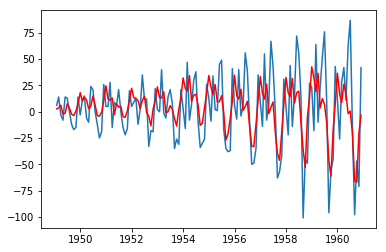

In [47]:
plt.plot(ts.diff())
plt.plot(model_fit.predict(), color = 'red')

# Store the values that the model would have predicted for our existing data
results = model.predict_in_sample()

# Start a new dataframe with those results as a column
results = pd.DataFrame(results)

# Create a new column in the dataframe that is equal to the dates from our original data
results['Month'] = ts.index

# Turn those dates into the index of our dataframe
results.set_index('Month', inplace = True)

# Plot our original dataset
plt.plot(ts)

# Plot our model's predictions of that same timeframe and color it red
plt.plot(np.exp(results), colour = 'red')

# We have to exponentiate our results as we have taken the log of them.

# Forecasting

####  We have a model that seems to pretty closely fit our existing data. We can extend that model to make a forecast about what is likely to happen in the future.

In [49]:
# Set a variable with the amount of months to forecast
periods_to_forecast = 24

In [50]:
# Create a range of future dates that is the length of
# the periods you've chosen to forecast
date_range = pd.date_range(ts.index[-1], periods = periods_to_forecast,
              freq='MS').strftime("%Y-%m-%d").tolist()

# Turn that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)

In [53]:
future_months['Prediction'] = forecast[0]

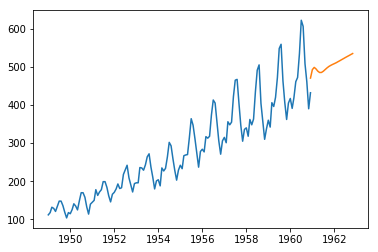

In [54]:
plt.plot(ts)
plt.plot(future_months)
plt.show()

In [55]:
future_months

,Prediction
Month,
1960-12-01,470.454142
1961-01-01,492.566063
1961-02-01,498.441553
1961-03-01,494.728376
1961-04-01,488.713433
1961-05-01,485.050545
1961-06-01,485.159714
1961-07-01,488.233803
1961-08-01,492.656788


# Evaluate and communicate

# We have taken a look at air passenger traffic from 1949 to 1960 to build a model that will predict what traffic will look like over the next couple of years.
Our historical data shows a positive increasing trend as well as severe seasonality, with traffic reaching highs in summer and lows in winter.
We decided to fit our data using an ARIMA model.
Our analysis suggests that air passenger traffic will continue to increase over the next couple of years. It is likely to follow similar seasonal patterns as well.

# ARIMA modelling is useful because it can make predictions using only a single variable time series, unlike regression, which requires multiple input variables to be considered.



## This advantage is also a disadvantage however, as our model cannot tell us what underlying variables are affecting its prediction. It is also worth noting that any shocks in data (for example, if there was no air passenger traffic for one year) are not well handled by ARIMA.

### If the FAA were to consider further analysis, it would be useful to run a full regression analysis using many other data points to understand what the underlying factors are for increasing air travel.